<a href="https://colab.research.google.com/github/smritisrikanth/Machine-Learning/blob/main/hw3_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

Mounted at /content/drive/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


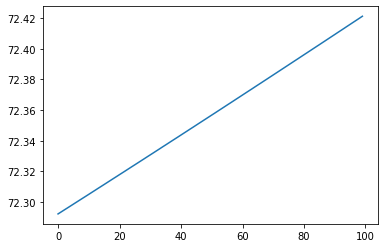

In [27]:
import torch
#from utils import *
import random
import time
import pdb
import json
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

n_letters=58
n_categories=18
n_hidden = 128
n_epochs = 100
print_every = 5000
plot_every = 1000
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn

class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Args:
            input_shape (int): size of the 1-hot embeddings for each character (this will be 58)
            hidden_layer_width (int): number of nodes in the single hidden layer within the model
            n_classes (int): number of output classes
        """
        super(RNN, self).__init__()
        ### TODO Implement the network architecture

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # self.f1 = torch.nn.Linear(input_size,hidden_size)
        # self.f2 = torch.nn.Linear(hidden_size,hidden_size)
        # self.f3 = torch.nn.Linear(hidden_size,hidden_size,bias = True)
        # self.f4 = torch.nn.Linear(hidden_size,output_size)

        self.f1 = torch.nn.Linear(input_size+hidden_size, hidden_size, bias = True)
        self.f2 = torch.nn.Linear(input_size+hidden_size, output_size, bias = True)
        self.g = torch.nn.Softmax()

    def forward(self, input, hidden):
        """Forward function accepts tensor of input data, returns tensor of output data.
        Modules defined in constructor are used, along with arbitrary operators on tensors
        """
        
        ### TODO Implement the forward function

        # input = self.f1(input)
        # hidden = self.f2(hidden)
        # hidden = self.f3(torch.cat([input,hidden],dim=1))
        # g = torch.nn.Softmax()
        # output = g(self.f4(hidden))

        hidden = self.f1(torch.cat([input,hidden],dim=1))
        output = self.g(self.f2(torch.cat([input,hidden],dim=1)))
        

        #your function will return the output y(t) and hidden h(t) from equation 1 in the docs
        return output, hidden 

    def initHidden(self):
        """
        This function initializes the first hidden state of the RNN as a zero tensor.
        """
        return torch.zeros(1, self.hidden_size)

def get_xy_pairs(names):
    #TODO 
    #process the names dict and convert into a list of (x,y) pairs. x is a 1-hot tensor of size (num_characters_in_name, 1, n_letters)
    #y is a scalar representing the category of the language, there are 18 languages, assign an index between 0-17 to each language and y represents this index.
    #you may make use of the nameToTensor() function in the utils.py file to help you with this function

    list_of_pairs = []
    y = 0

    for language in names.keys():
      for name in language:
        x = nameToTensor(name)
        list_of_pairs.append([x,y])
      y = y+1

    return list_of_pairs

def create_train_and_test_set(list_of_pairs):
    #TODO 
    #process the list of (x,y) pairs and split them 80-20 into train and test set
    #train_x is a list of name embeddings each of size (num_characters_in_name, 1, n_letters), train_y is the correponding list of language category index. Same for test_x and test_y

    x = []
    y = []
    for pair in list_of_pairs:
      x.append(pair[0])
      y.append(pair[1])

    train_x, test_x, train_y, test_y = train_test_split(x,y,test_size = 0.2)

    # random.seed(0)

    # train_x = []
    # train_y = []
    # test_x = []
    # test_y = []

    # for pair in list_of_pairs:
    #   if random.randrange(0,10) > 1:
    #     train_x.append(pair[0])
    #     train_y.append(pair[1])
    #   else:
    #     test_x.append(pair[0])
    #     test_y.append(pair[1])

    return train_x, train_y, test_x, test_y

rnn = RNN(n_letters, n_hidden, n_categories)
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.NLLLoss()

def train(train_x, train_y):
    """train_x and train_y are lists with names and correspoonding labels"""
    loss = 0
    cel = []
    for x, y in zip(train_x, train_y):
        hidden = rnn.initHidden()
        for i in range(x.size()[0]):
            output, hidden = rnn(x[i], hidden)

        loss += criterion(torch.log(output), torch.tensor(y).unsqueeze(0)) #the unsqueeze converts the scalar y to a 1D tensor

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


def test(train_x, train_y):
    """train_x and train_y are lists with names and correspoonding labels"""
    loss = 0
    with torch.no_grad(): 
        for x, y in zip(train_x, train_y):
            hidden = rnn.initHidden()
            for i in range(x.size()[0]):
                output, hidden = rnn(x[i], hidden)

            loss += criterion(torch.log(output), torch.tensor(y).unsqueeze(0)) #the unsqueeze converts the scalar y to a 1D tensor

    return loss


# Keep track of losses for plotting
current_loss = 0
all_losses = []

#names is your dataset in python dictionary form. Keys are languages and values are list of words belonging to that language
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)
with open('/content/drive/My Drive/names.json', 'r') as fp:
    names = json.load(fp)

list_of_pairs = get_xy_pairs(names)
train_x, train_y, test_x, test_y = create_train_and_test_set(list_of_pairs)

for epoch in range(1, n_epochs + 1):
    train(train_x, train_y)
    current_loss = test(test_x, test_y)
    all_losses.append(current_loss)


plt.plot(all_losses)

#saving your model
torch.save(rnn, 'rnn.pt')